# Imports and Data Download

In [ ]:
from torchvision import datasets
from torchvision import transforms
from torch.autograd import Variable

import torch
import torch.nn as nn
from torchvision.utils import make_grid
from IPython.display import Image
import torchvision.transforms.functional as F
from torchvision.utils import make_grid
import os

from tqdm import tqdm
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
import cv2
import csv
from PIL import Image, ImageDraw

from torchvision.models import detection
import pickle as pickle
import torchvision
import torchvision.transforms as Tr
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.transforms.functional import pil_to_tensor
import pycocotools
from torchvision.models.detection import ssd300_vgg16,retinanet_resnet50_fpn,fasterrcnn_resnet50_fpn_v2,fasterrcnn_mobilenet_v3_large_fpn
from pycocotools.coco import COCO
from torchvision.utils import draw_bounding_boxes
from torchvision.transforms.functional import to_pil_image


import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader



device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
!pip install opencv-contrib-python
import cv2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# After uploading kaggle.json use this script to download dataset:
!ls -lha kaggle.json
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle competitions download -c iwildcam-2019-fgvc6




-rw-r--r-- 1 root root 71 Feb 27 05:16 kaggle.json
100% 43.4G/43.4G [05:16<00:00, 212MB/s]
100% 43.4G/43.4G [05:16<00:00, 147MB/s]


In [ ]:
# unzip all images:
!mkdir train_images
!mkdir test_images
!unzip iwildcam-2019-fgvc6.zip
!rm iwildcam-2019-fgvc6.zip
!unzip train_images.zip -d train_images
!rm train_images.zip
!unzip test_images.zip -d test_images
!rm test_images.zip

In [ ]:
# Download and unzip supplement train dataset
!mkdir supp_train
!wget https://lilablobssc.blob.core.windows.net/iwildcam2019/iWildCam_2019_iNat_Idaho.tar.gz
!tar xvf iWildCam_2019_iNat_Idaho.tar.gz -C supp_train/

In [ ]:
# Download and load imagenet and coco annotations and labels
!wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip
!unzip annotations_trainval2017.zip


--2023-02-27 05:21:21--  https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10472 (10K) [text/plain]
Saving to: ‘imagenet_classes.txt’

imagenet_classes.tx 100%[===================>]  10.23K  --.-KB/s    in 0s      

2023-02-27 05:21:21 (116 MB/s) - ‘imagenet_classes.txt’ saved [10472/10472]

--2023-02-27 05:21:22--  http://images.cocodataset.org/annotations/annotations_trainval2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.169.185, 52.217.142.241, 52.217.88.4, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.169.185|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252907541 (241M) [application/zip]
Saving to: ‘

In [ ]:
annFile='annotations/instances_val2017.json'
coco=COCO(annFile)

loading annotations into memory...
Done (t=0.56s)
creating index...
index created!


# Reading CSV Files

In [ ]:
test_df = pd.read_csv("test.csv")

In [ ]:
test_df.head()

date_captured                                 file_name  frame_num  \
0  03-Jan-2016 11:30:56  bce932f6-2bf6-11e9-bcad-06f10d5896c4.jpg          1   
1  03-Jan-2016 11:30:57  bce932f7-2bf6-11e9-bcad-06f10d5896c4.jpg          2   
2  03-Jan-2016 11:30:58  bce932f8-2bf6-11e9-bcad-06f10d5896c4.jpg          3   
3  03-Jan-2016 11:30:59  bce932f9-2bf6-11e9-bcad-06f10d5896c4.jpg          4   
4  03-Jan-2016 11:31:00  bce932fa-2bf6-11e9-bcad-06f10d5896c4.jpg          5   

                                     id  location  \
0  bce932f6-2bf6-11e9-bcad-06f10d5896c4        37   
1  bce932f7-2bf6-11e9-bcad-06f10d5896c4        37   
2  bce932f8-2bf6-11e9-bcad-06f10d5896c4        37   
3  bce932f9-2bf6-11e9-bcad-06f10d5896c4        37   
4  bce932fa-2bf6-11e9-bcad-06f10d5896c4        37   

                       rights_holder                                seq_id  \
0  Idaho Department of Fish and Game  6e9ac61c-2e32-11e9-90ef-dca9047ef277   
1  Idaho Department of Fish and Game  6e9ac61c-2e32-11e9-90ef-dca9047ef277   
2  Idaho Department of Fish and Game  6e9ac61c-2e32-11e9-90ef-dca9047ef277   
3  Idaho Department of Fish and Game  6e9ac61c-2e32-11e9-90ef-dca9047ef277   
4  Idaho Department of Fish and Game  6e9ac61c-2e32-11e9-90ef-dca9047ef277   

   seq_num_frames  width  height  
0               5   1024     726  
1               5   1024     726  
2               5   1024     726  
3               5   1024     726  
4               5   1024     726

In [ ]:
train_df = pd.read_csv("train.csv")

In [ ]:
train_df.head()

category_id        date_captured                                 file_name  \
0           19  2011-05-13 23:43:18  5998cfa4-23d2-11e8-a6a3-ec086b02610b.jpg   
1           19  2012-03-17 03:48:44  588a679f-23d2-11e8-a6a3-ec086b02610b.jpg   
2            0  2014-05-11 11:56:46  59279ce3-23d2-11e8-a6a3-ec086b02610b.jpg   
3            0  2013-10-06 02:00:00  5a2af4ab-23d2-11e8-a6a3-ec086b02610b.jpg   
4            0  2011-07-12 13:11:16  599fbd89-23d2-11e8-a6a3-ec086b02610b.jpg   

   frame_num                                    id  location  rights_holder  \
0          1  5998cfa4-23d2-11e8-a6a3-ec086b02610b        33   Justin Brown   
1          2  588a679f-23d2-11e8-a6a3-ec086b02610b       115   Justin Brown   
2          1  59279ce3-23d2-11e8-a6a3-ec086b02610b        96  Erin Boydston   
3          1  5a2af4ab-23d2-11e8-a6a3-ec086b02610b        57  Erin Boydston   
4          3  599fbd89-23d2-11e8-a6a3-ec086b02610b        46   Justin Brown   

                                 seq_id  seq_num_frames  width  height  
0  6f084ccc-5567-11e8-bc84-dca9047ef277               3   1024     747  
1  6f12067d-5567-11e8-b3c0-dca9047ef277               3   1024     747  
2  6faa92d1-5567-11e8-b1ae-dca9047ef277               1   1024     747  
3  6f7d4702-5567-11e8-9e03-dca9047ef277               1   1024     747  
4  6f1728a1-5567-11e8-9be7-dca9047ef277               3   1024     747

**Observing categories in training set:**

In [ ]:
classes_wild = {0: 'empty', 1: 'deer', 2: 'moose', 3: 'squirrel', 4: 'rodent', 5: 'small_mammal',
                6: 'elk', 7: 'pronghorn_antelope', 8: 'rabbit', 9: 'bighorn_sheep', 10: 'fox', 11: 'coyote',
                12: 'black_bear', 13: 'raccoon', 14: 'skunk', 15: 'wolf', 16: 'bobcat', 17: 'cat',
                18: 'dog', 19: 'opossum', 20: 'bison', 21: 'mountain_goat', 22: 'mountain_lion'}

In [ ]:
train_df['classes_wild'] = train_df['category_id'].apply(lambda cw: classes_wild[cw])

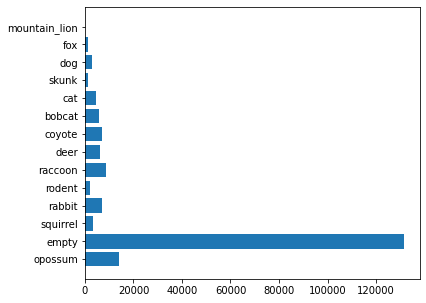

In [ ]:
classes = train_df['classes_wild'].unique()
fig, ax = plt.subplots(figsize=(6,5))
bars = ax.barh(classes, [train_df['classes_wild'].value_counts()[classs] for classs in classes])
plt.show()

In [ ]:
train_df['classes_wild'].unique()

array(['opossum', 'empty', 'squirrel', 'rabbit', 'rodent', 'raccoon',
       'deer', 'coyote', 'bobcat', 'cat', 'skunk', 'dog', 'fox',
       'mountain_lion'], dtype=object)

In [ ]:
a=train_df['classes_wild'].value_counts()

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


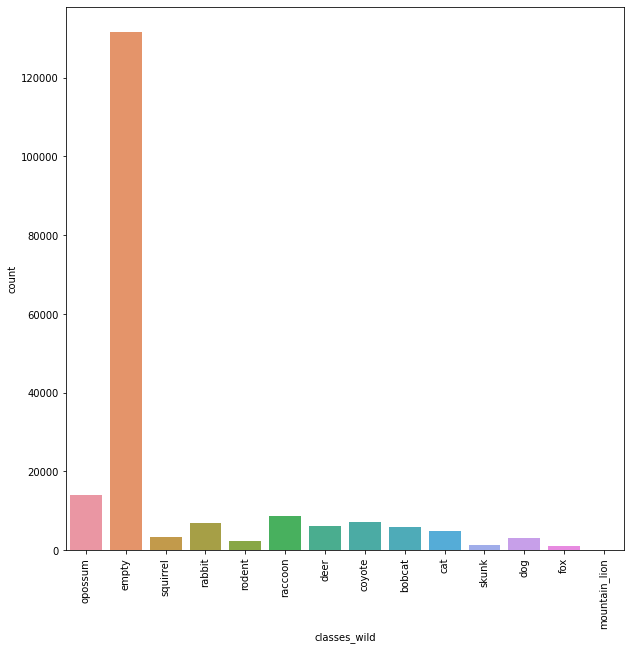

In [ ]:
fig = plt.figure(figsize=(10,10))
sns.countplot(train_df.classes_wild)
plt.xticks(rotation=90)
plt.savefig("count1.pdf")
plt.show()


In [ ]:
train_df['category_id'].value_counts()


0     131457
19     14106
13      8623
11      7209
8       6938
1       6102
16      5975
17      4759
3       3398
18      3035
4       2210
14      1361
10      1093
22        33
Name: category_id, dtype: int64

In [ ]:
sorted(train_df['category_id'].unique())

[0, 1, 3, 4, 8, 10, 11, 13, 14, 16, 17, 18, 19, 22]

In [ ]:
train_df['classes_wild'].value_counts()

empty            131457
opossum           14106
raccoon            8623
coyote             7209
rabbit             6938
deer               6102
bobcat             5975
cat                4759
squirrel           3398
dog                3035
rodent             2210
skunk              1361
fox                1093
mountain_lion        33
Name: classes_wild, dtype: int64

We note that there are missing categories, and that empty category has significantly more samples than others

# Loading supplemental data (iNat Idaho)
https://www.kaggle.com/code/rbarman/iwildcam-2019-inat-idaho-resized

In [ ]:
import json
with open('supp_train/iWildCam_2019_iNat_Idaho/iWildCam_2019_iNat_Idaho.json') as json_data:
  supp_train = json.load(json_data)

In [ ]:
image_df = pd.DataFrame.from_dict(supp_train['images'])
image_df = image_df[['file_name','id']]
image_df.rename(columns={'id':'image_id'}, inplace=True)
image_df.head()

file_name  image_id
0  train_val2017/Mammalia/Marmota flaviventris/6e...         1
1  train_val2017/Mammalia/Marmota flaviventris/dc...         2
2  train_val2017/Mammalia/Marmota flaviventris/f9...         3
3  train_val2017/Mammalia/Marmota flaviventris/4b...         4
4  train_val2017/Mammalia/Marmota flaviventris/ab...         5

In [ ]:
annotation_df = pd.DataFrame.from_dict(supp_train['annotations'])
annotation_df = annotation_df[['category_id','image_id']]
annotation_df.head()

category_id  image_id
0            3         1
1            3         2
2            3         3
3            3         4
4            3         5

In [ ]:
supp_df = pd.merge(image_df, annotation_df, on='image_id', how='inner')

supp_df['is_supp'] = True
supp_df['file_path'] = supp_df['file_name'].apply(lambda x: f'supp_train/iWildCam_2019_iNat_Idaho/{x}')
supp_df.drop(columns=['image_id','file_name'],inplace=True)

supp_df.head()

category_id  is_supp                                          file_path
0            3     True  supp_train/iWildCam_2019_iNat_Idaho/train_val2...
1            3     True  supp_train/iWildCam_2019_iNat_Idaho/train_val2...
2            3     True  supp_train/iWildCam_2019_iNat_Idaho/train_val2...
3            3     True  supp_train/iWildCam_2019_iNat_Idaho/train_val2...
4            5     True  supp_train/iWildCam_2019_iNat_Idaho/train_val2...

In [ ]:
train_df['file_path'] = train_df['id'].apply(lambda x: f'train_images/{x}.jpg')
train_df = train_df[['file_path','category_id']]
train_df['is_supp'] = False
train_df.head()

<ipython-input-147-5c9dce4a1219>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['is_supp'] = False


file_path  category_id  is_supp
0  train_images/5998cfa4-23d2-11e8-a6a3-ec086b026...           19    False
1  train_images/588a679f-23d2-11e8-a6a3-ec086b026...           19    False
2  train_images/59279ce3-23d2-11e8-a6a3-ec086b026...            0    False
3  train_images/5a2af4ab-23d2-11e8-a6a3-ec086b026...            0    False
4  train_images/599fbd89-23d2-11e8-a6a3-ec086b026...            0    False

In [ ]:
complete_train_df = pd.concat([train_df,supp_df], ignore_index = True)
complete_train_df.head()

file_path  category_id  is_supp
0  train_images/5998cfa4-23d2-11e8-a6a3-ec086b026...           19    False
1  train_images/588a679f-23d2-11e8-a6a3-ec086b026...           19    False
2  train_images/59279ce3-23d2-11e8-a6a3-ec086b026...            0    False
3  train_images/5a2af4ab-23d2-11e8-a6a3-ec086b026...            0    False
4  train_images/599fbd89-23d2-11e8-a6a3-ec086b026...            0    False

**Observing categories in complete training set:**

In [ ]:
complete_train_df["category_id"].value_counts()

0     131457
19     14106
1      11199
13     11163
11      9490
8       8948
3       8111
16      7213
17      4954
5       3411
18      3035
10      2281
4       2274
14      2077
12       905
7        429
20       314
9        254
22       179
21       144
15        37
2         22
6          9
Name: category_id, dtype: int64

In [ ]:
complete_train_df['classes_wild'] = complete_train_df['category_id'].apply(lambda cw: classes_wild[cw])

In [ ]:
complete_train_df["classes_wild"].value_counts()

empty                 131457
opossum                14106
deer                   11199
raccoon                11163
coyote                  9490
rabbit                  8948
squirrel                8111
bobcat                  7213
cat                     4954
small_mammal            3411
dog                     3035
fox                     2281
rodent                  2274
skunk                   2077
black_bear               905
pronghorn_antelope       429
bison                    314
bighorn_sheep            254
mountain_lion            179
mountain_goat            144
wolf                      37
moose                     22
elk                        9
Name: classes_wild, dtype: int64

In [ ]:
sorted(complete_train_df["category_id"].unique())

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22]

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='category_id', ylabel='count'>

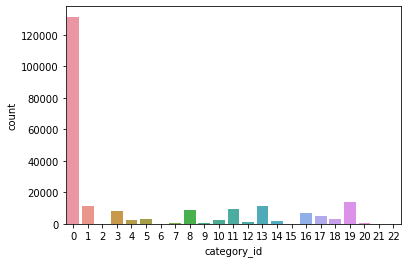

In [ ]:
sns.countplot(complete_train_df.category_id)

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


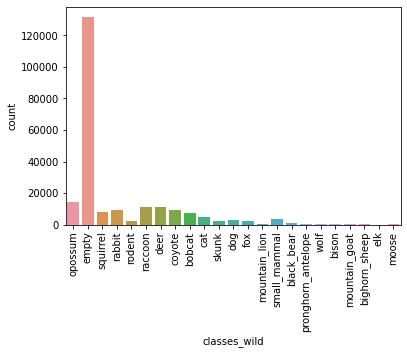

In [ ]:
sns.countplot(complete_train_df.classes_wild)
plt.xticks(rotation=90)
plt.show()

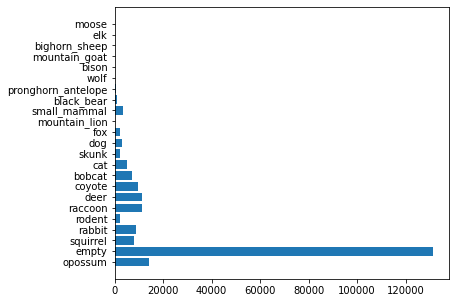

In [ ]:
classes = complete_train_df['classes_wild'].unique()
fig, ax = plt.subplots(figsize=(6,5))
bars = ax.barh(classes, [complete_train_df['classes_wild'].value_counts()[classs] for classs in classes])
plt.show()

Now there are samples from all categories, but still empty is significantly larger

# Image Pre-Processing
https://www.kaggle.com/code/seriousran/image-pre-processing-for-wild-images/notebook

In [ ]:
wb = cv2.xphoto.createSimpleWB()
wb.setP(0.4)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(16, 16))

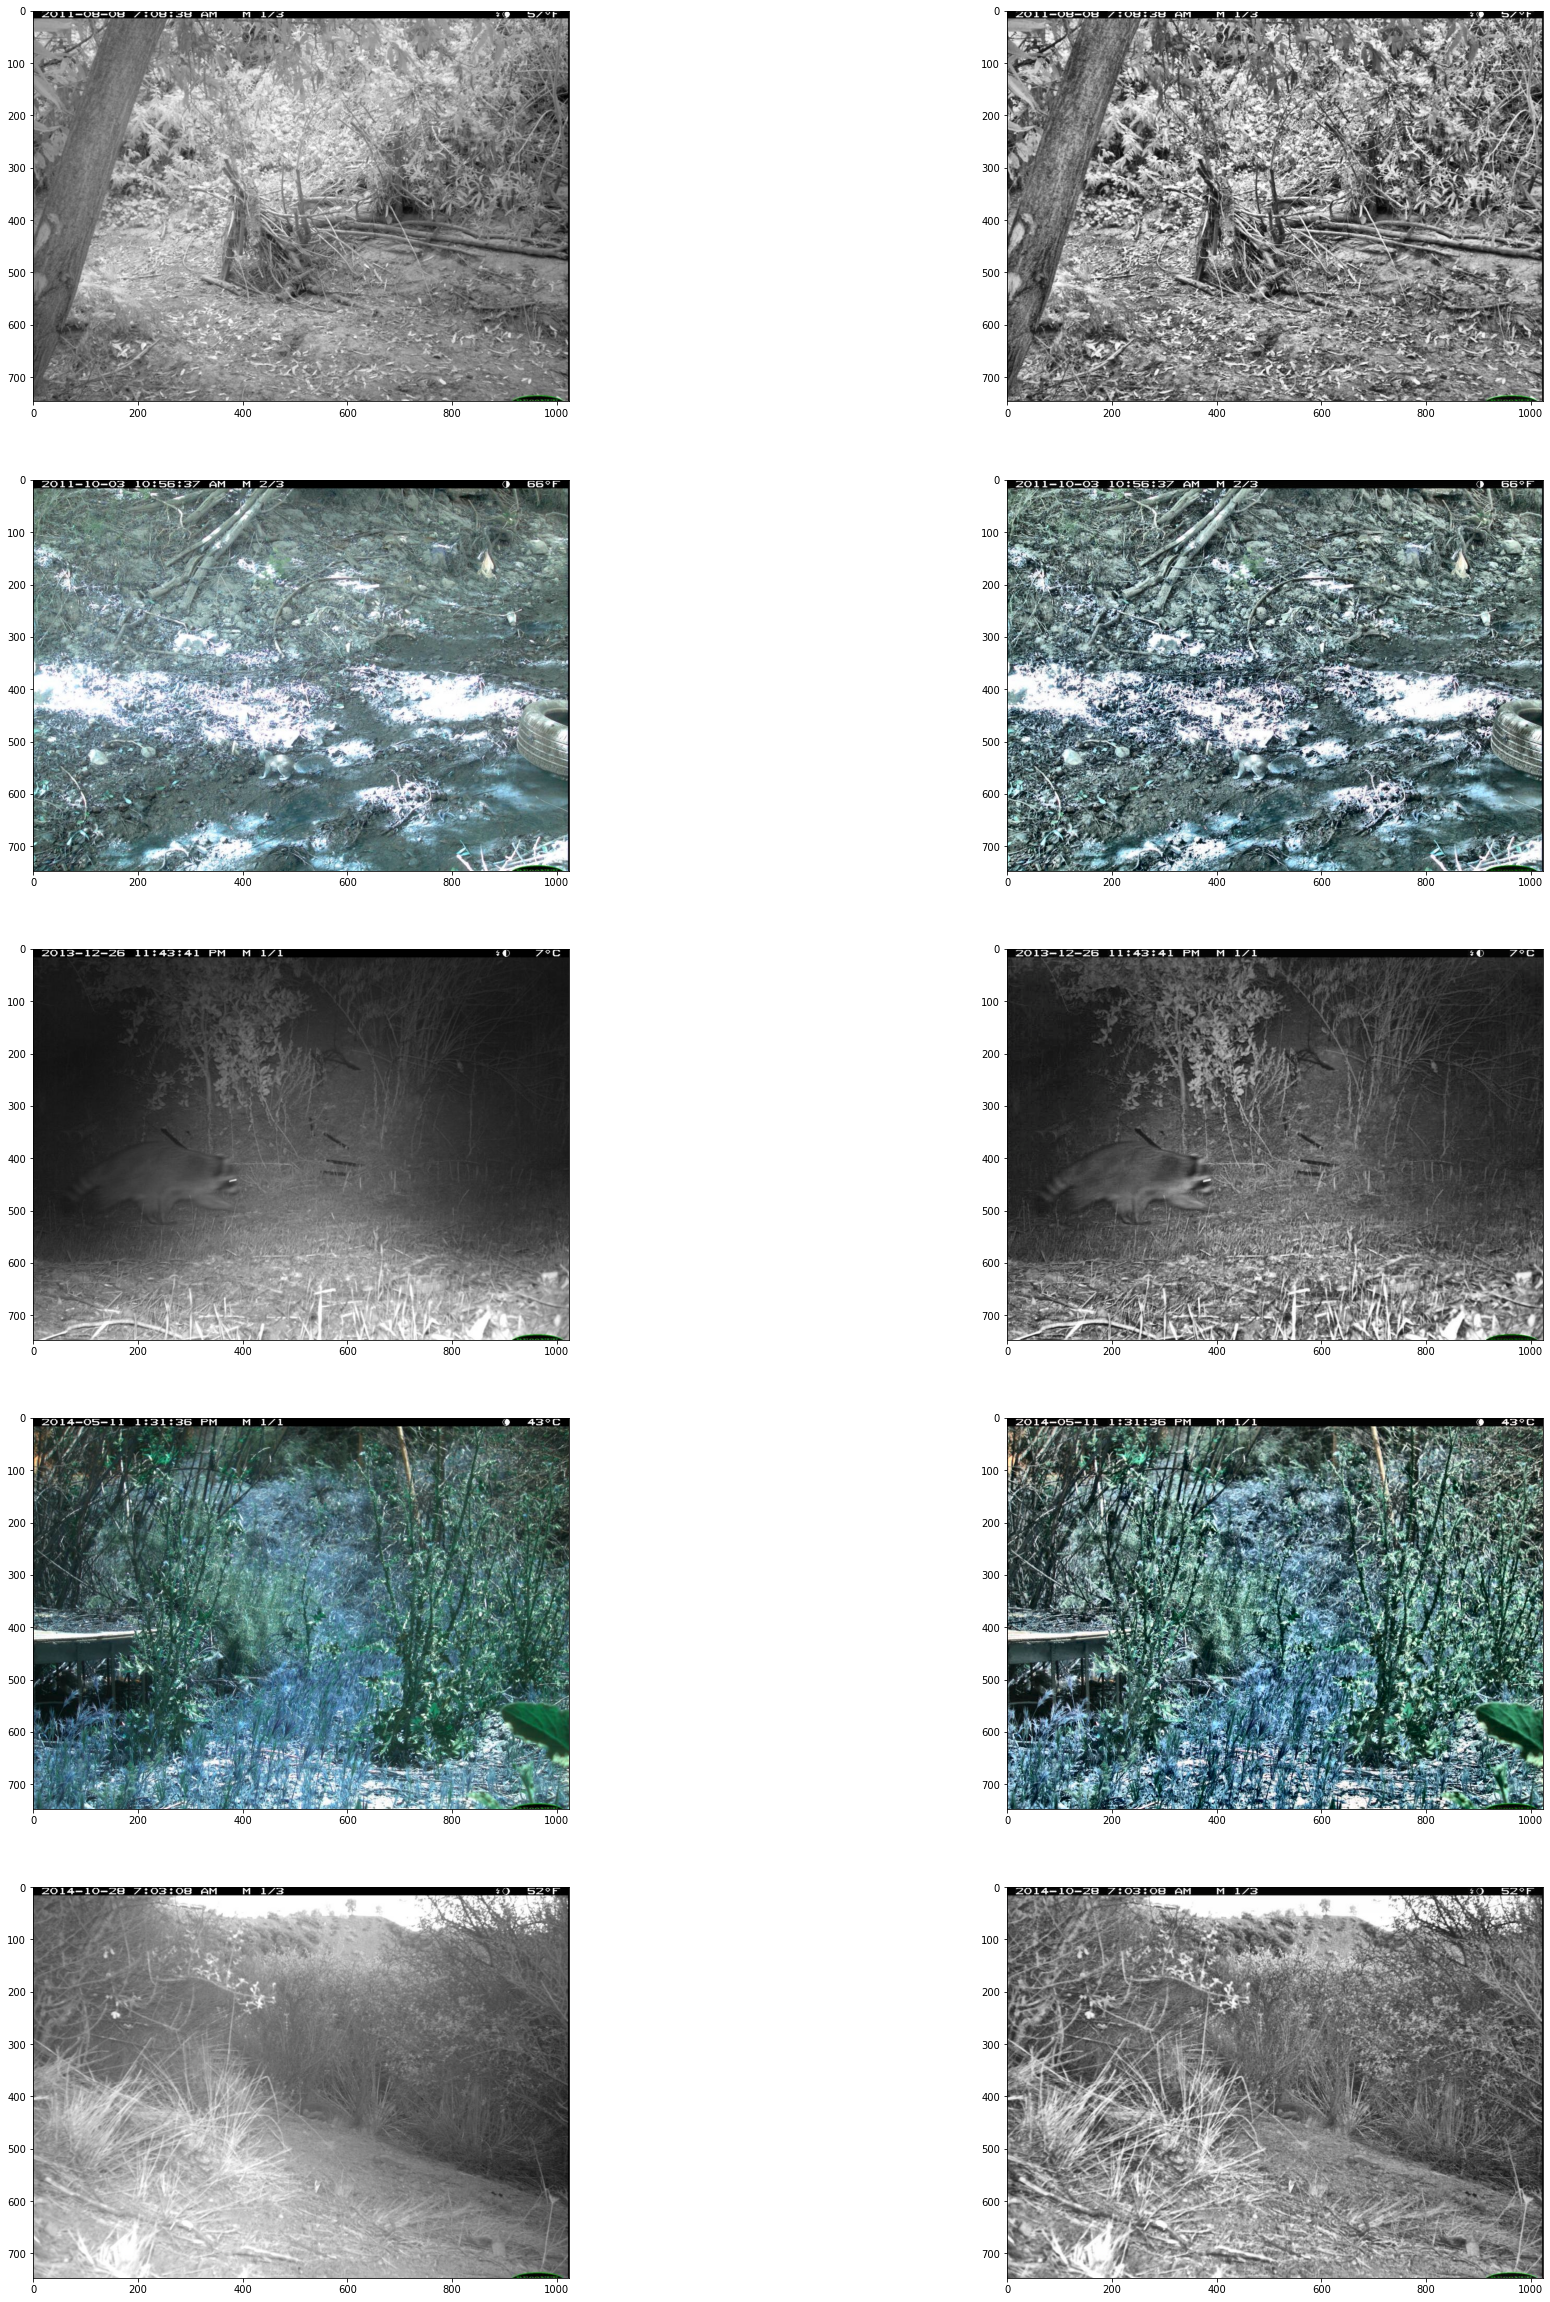

In [ ]:
num_show = 5
fig=plt.figure(figsize=(32, 128))
wb = cv2.xphoto.createSimpleWB()
wb.setP(0.4)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(16, 16))
for idx, train_img in enumerate(complete_train_df["file_path"][152478:]):
    if idx >= num_show:
        break
    
    temp_img = cv2.imread(train_img, cv2.IMREAD_COLOR)        
    
    img_wb = wb.balanceWhite(temp_img)

    img_lab = cv2.cvtColor(img_wb, cv2.COLOR_BGR2Lab)

    l, a, b = cv2.split(img_lab)
    res_l = clahe.apply(l)
    res = cv2.merge((res_l, a, b))

    res = cv2.cvtColor(res, cv2.COLOR_Lab2BGR)
    fig.add_subplot(15, 2, 2 * idx + 1)
    # plt.imsave(f"original{idx}.png",temp_img)
    plt.imshow(temp_img)
    fig.add_subplot(15, 2, 2 * idx + 2)
    # plt.imsave(f"prep{idx}.png",res)
    plt.imshow(res)
plt.show()

In [ ]:
def preprocess_images(img_path):
  temp_img = cv2.imread(img_path, cv2.IMREAD_COLOR)        
  img_wb = wb.balanceWhite(temp_img)
  img_lab = cv2.cvtColor(img_wb, cv2.COLOR_BGR2Lab)
  l, a, b = cv2.split(img_lab)
  res_l = clahe.apply(l)
  res = cv2.merge((res_l, a, b))
  res = cv2.cvtColor(res, cv2.COLOR_Lab2RGB)
  return res

# Using Detector
We use the pre-trained object detector: "fasterrcnn_mobilenet_v3_large_fpn" to filter the empty images from the training set.

It was train to detect objects and label them according to COCO labels: https://github.com/amikelive/coco-labels/blob/master/coco-labels-paper.txt

First we load and pre-process the image, then we apply the detector and filter the labels with a threshold of 0.3. If all labels are of index 15 or below (see link for labels, these are the labels of humans and vehicles) we classify the photo as empty (0), otherwise, we classify the photo as with animal (1).


In [ ]:
def preprocess_detect_and_label(img_path,model):
  transform = transforms.ToTensor()
  preprocessed_im = preprocess_images(img_path)
  tensor_im = transform(preprocessed_im).unsqueeze(dim=0)
  tensor_im_int =(tensor_im*255).type(torch.uint8)
  tensor_im = tensor_im.to(device)
  img_preds = model(tensor_im)
  # print(f"Preds before: {img_preds}")
  img_preds[0]["boxes"] = img_preds[0]["boxes"][img_preds[0]["scores"] > 0.4]
  img_preds[0]["labels"] = img_preds[0]["labels"][img_preds[0]["scores"] > 0.4]
  img_preds[0]["scores"] = img_preds[0]["scores"][img_preds[0]["scores"] > 0.4]
  # print(f"Preds after: {img_preds}")
  img_labels = coco.loadCats(img_preds[0]["labels"].cpu().numpy())
  # print(f"Labels: {img_labels}")
  # img_annot_labels = ["{}-{:.2f}".format(label["name"], prob) for label, prob in zip(img_labels, img_preds[0]["scores"].cpu().detach().numpy())]
  # img_output = draw_bounding_boxes(image=tensor_im_int[0],
  #                                 boxes=img_preds[0]["boxes"],
  #                                 labels=img_annot_labels,
  #                                 colors=["red" if label["name"]=="person" else "green" for label in img_labels],
  #                                 width=2
  #                                 )
  # fig = plt.figure()
  # back_transform = transforms.ToPILImage()
  # final=back_transform(img_output)
  # plt.imshow(final)
  return img_preds[0]["labels"].cpu().numpy()



In [ ]:
complete_train_df.to_csv("complete_train_df.csv")

In [ ]:
preds = []
model = fasterrcnn_mobilenet_v3_large_fpn(pretrained =True, progress=False)
model.eval()
model.to(device)
for i,file_path in tqdm(enumerate(complete_train_df["file_path"])):
  if i%20000 ==0:
    preds_csv = pd.DataFrame(preds)
    preds_csv.to_csv(f"thresh_04_preprocessed_detection_train_full_fasterrcnn_mobilenet_v3_large_fpn-{i}.csv")
  labels = preprocess_detect_and_label(file_path,model)
  if len(labels[labels>15]) >0:
    preds.append(1)
  else:
    preds.append(0)
  torch.cuda.empty_cache()


/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_MobileNet_V3_Large_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_MobileNet_V3_Large_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
222012it [3:20:55, 18.42it/s]


In [ ]:
preds_csv = pd.DataFrame(preds)
preds_csv.to_csv("preprocessed_detection_train_full_fasterrcnn_mobilenet_v3_large_fpn.csv")

In [ ]:
preds = pd.read_csv("preprocessed_detection_train_full_fasterrcnn_mobilenet_v3_large_fpn.csv")

In [ ]:
preds =np.array(preds["0"])

Total accuracy of the detector:

In [ ]:
accuracy = 0
for i,pred in enumerate(preds):
  if pred ==0:
    if complete_train_df.iloc[i,:]["category_id"]==0:
      accuracy+=1
  else:
    if complete_train_df.iloc[i,:]["category_id"]!=0:
      accuracy+=1

In [ ]:
print(f"{round(100*accuracy/len(complete_train_df),2)}%")

81.67%


In [ ]:
accuracy_empty = 0
accuracy_animal = 0
false_positive = 0
false_negative = 0 
animals_missed = {}
for i in range(23):
  animals_missed[i]=0
for idx, predicted_label in enumerate(preds):
  true_label = complete_train_df.iloc[idx,:]["category_id"]
  if predicted_label == 0 and true_label == 0:
    accuracy_empty += 1
  elif predicted_label == 1 and true_label != 0:
    accuracy_animal += 1
  elif predicted_label ==0 and true_label != 0:
    false_negative += 1
    animals_missed[true_label] +=1
  elif predicted_label ==1 and true_label == 0:
    false_positive += 1



In [ ]:
total = len(complete_train_df)
num_empty = len(complete_train_df[complete_train_df["category_id"]==0])
num_animals = total - num_empty

In [ ]:
df_conf = complete_train_df.copy()
df_conf.loc[df_conf["category_id"]!=0]=1
cat_id = df_conf["category_id"]
cat_id

0         1
1         1
2         0
3         0
4         0
         ..
222007    1
222008    1
222009    1
222010    1
222011    1
Name: category_id, Length: 222012, dtype: int64

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
preds

array([1, 0, 0, ..., 1, 1, 0])

Checking accuracy of only empty and only animal images, false positive and false negative

In [ ]:
print(f"Empty Images Accuracy: {round(100*accuracy_empty/num_empty,2)}%")

Empty Images Accuracy: 87.42%


In [ ]:
print(f"Animal Images Accuracy: {round(100*accuracy_animal/num_animals,2)}%")

Animal Images Accuracy: 73.31%


In [ ]:
print(f"False Positive (Detected animal in empty image): {round(100*false_positive/total,2)}%")

False Positive (Detected animal in empty image): 7.45%


In [ ]:
print(f"False Negative (Did not Detect Animal): {round(100*false_negative/total,2)}%")

False Negative (Did not Detect Animal): 10.88%


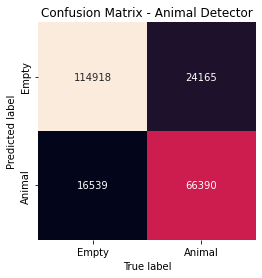

In [ ]:
conf_mat = confusion_matrix(cat_id,preds)
ticks = ["Empty","Animal"]
sns.heatmap(conf_mat.T, square=True, annot=True, fmt='d', cbar=False, xticklabels=ticks, yticklabels=ticks)
plt.title("Confusion Matrix - Animal Detector")
plt.xlabel('True label')
plt.ylabel('Predicted label');

In [ ]:
complete_train_df['classes_wild'] = complete_train_df['category_id'].apply(lambda cw: classes_wild[cw])

Miss rate of animals:

In [ ]:
missed_dict = {}
for cat in sorted(complete_train_df["category_id"].unique()):
  if cat !=0:
    missed_dict[classes_wild[cat]]=round((animals_missed[cat])*100/(len(complete_train_df[complete_train_df['category_id']==cat])),2)

for item in dict(sorted(missed_dict.items(), key=lambda item: item[1],reverse=True)).items():
    print(f"{item[0]} missed: {item[1]}%")

rodent missed: 38.39%
rabbit missed: 38.3%
opossum missed: 38.03%
squirrel missed: 37.32%
small_mammal missed: 28.61%
bobcat missed: 26.13%
raccoon missed: 24.36%
mountain_lion missed: 24.02%
coyote missed: 21.76%
dog missed: 21.48%
skunk missed: 19.93%
cat missed: 18.17%
mountain_goat missed: 17.36%
wolf missed: 16.22%
black_bear missed: 16.02%
fox missed: 14.25%
deer missed: 11.17%
pronghorn_antelope missed: 8.62%
bighorn_sheep missed: 7.87%
moose missed: 4.55%
bison missed: 3.18%
elk missed: 0.0%


In [ ]:
pred_np =  np.array(preds)
indexes = np.where(pred_np == 1)[0]

Filter train according to detector

In [ ]:
filtered_train = complete_train_df.loc[indexes]

Remove the undetected empties

In [ ]:
filtered_train = filtered_train[filtered_train["category_id"]!=0]

Observing detected animals labels

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


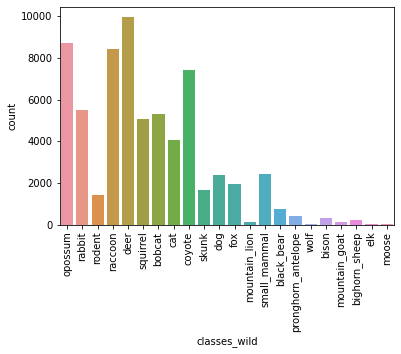

In [ ]:
sns.countplot(filtered_train.classes_wild)
plt.xticks(rotation=90)
plt.show()

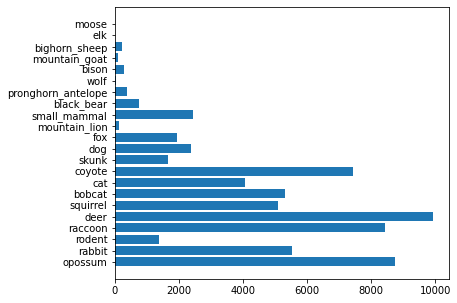

In [ ]:
classes = filtered_train['classes_wild'].unique()
fig, ax = plt.subplots(figsize=(6,5))
bars = ax.barh(classes, [filtered_train['classes_wild'].value_counts()[classs] for classs in classes])
plt.show()

In [ ]:
filtered_train['classes_wild'].value_counts()

deer                  9948
opossum               8742
raccoon               8444
coyote                7425
rabbit                5521
bobcat                5328
squirrel              5084
cat                   4054
small_mammal          2435
dog                   2383
fox                   1956
skunk                 1663
rodent                1401
black_bear             760
pronghorn_antelope     392
bison                  304
bighorn_sheep          234
mountain_lion          136
mountain_goat          119
wolf                    31
moose                   21
elk                      9
Name: classes_wild, dtype: int64

In [ ]:
filtered_train.to_csv("filtered_train_preprocessed.csv")

In [ ]:
filtered_train = pd.read_csv("filtered_train_preprocessed.csv")

FileNotFoundError: ignored

In [ ]:
filtered_train

file_path  category_id  \
0       train_images/5998cfa4-23d2-11e8-a6a3-ec086b026...           19   
6       train_images/59fae563-23d2-11e8-a6a3-ec086b026...            8   
12      train_images/595f7b9c-23d2-11e8-a6a3-ec086b026...            4   
14      train_images/5883e97b-23d2-11e8-a6a3-ec086b026...           19   
15      train_images/58d47cf1-23d2-11e8-a6a3-ec086b026...           19   
...                                                   ...          ...   
222006  supp_train/iWildCam_2019_iNat_Idaho/train_val2...            3   
222007  supp_train/iWildCam_2019_iNat_Idaho/train_val2...            1   
222008  supp_train/iWildCam_2019_iNat_Idaho/train_val2...            1   
222009  supp_train/iWildCam_2019_iNat_Idaho/train_val2...           11   
222010  supp_train/iWildCam_2019_iNat_Idaho/train_val2...            5   

        is_supp  classes_wild  
0         False       opossum  
6         False        rabbit  
12        False        rodent  
14        False       opossum  
15        False       opossum  
...         ...           ...  
222006     True      squirrel  
222007     True          deer  
222008     True          deer  
222009     True        coyote  
222010     True  small_mammal  

[66390 rows x 4 columns]

After the detector we are left with 66390 images of images that the detector identified. Since it achieved relatively high accuracy, we will use it on the test set, to filter between empty and non-empty images. Then we will train of the filtered train set and predict using the filtered test set.

In [ ]:
test_df['file_path'] = test_df['id'].apply(lambda x: f'test_images/{x}.jpg')
test_df

date_captured                                 file_name  \
0       03-Jan-2016 11:30:56  bce932f6-2bf6-11e9-bcad-06f10d5896c4.jpg   
1       03-Jan-2016 11:30:57  bce932f7-2bf6-11e9-bcad-06f10d5896c4.jpg   
2       03-Jan-2016 11:30:58  bce932f8-2bf6-11e9-bcad-06f10d5896c4.jpg   
3       03-Jan-2016 11:30:59  bce932f9-2bf6-11e9-bcad-06f10d5896c4.jpg   
4       03-Jan-2016 11:31:00  bce932fa-2bf6-11e9-bcad-06f10d5896c4.jpg   
...                      ...                                       ...   
153725  25-Apr-2016 09:04:21  88613521-2c22-11e9-bcad-06f10d5896c4.jpg   
153726  25-Apr-2016 09:04:23  88613522-2c22-11e9-bcad-06f10d5896c4.jpg   
153727  25-Apr-2016 09:04:27  88613523-2c22-11e9-bcad-06f10d5896c4.jpg   
153728  25-Apr-2016 09:04:29  88613524-2c22-11e9-bcad-06f10d5896c4.jpg   
153729  25-Apr-2016 09:08:57  89994900-2c22-11e9-bcad-06f10d5896c4.jpg   

        frame_num                                    id  location  \
0               1  bce932f6-2bf6-11e9-bcad-06f10d5896c4        37   
1               2  bce932f7-2bf6-11e9-bcad-06f10d5896c4        37   
2               3  bce932f8-2bf6-11e9-bcad-06f10d5896c4        37   
3               4  bce932f9-2bf6-11e9-bcad-06f10d5896c4        37   
4               5  bce932fa-2bf6-11e9-bcad-06f10d5896c4        37   
...           ...                                   ...       ...   
153725         29  88613521-2c22-11e9-bcad-06f10d5896c4        16   
153726         30  88613522-2c22-11e9-bcad-06f10d5896c4        16   
153727         31  88613523-2c22-11e9-bcad-06f10d5896c4        16   
153728         32  88613524-2c22-11e9-bcad-06f10d5896c4        16   
153729          1  89994900-2c22-11e9-bcad-06f10d5896c4        16   

                            rights_holder  \
0       Idaho Department of Fish and Game   
1       Idaho Department of Fish and Game   
2       Idaho Department of Fish and Game   
3       Idaho Department of Fish and Game   
4       Idaho Department of Fish and Game   
...                                   ...   
153725  Idaho Department of Fish and Game   
153726  Idaho Department of Fish and Game   
153727  Idaho Department of Fish and Game   
153728  Idaho Department of Fish and Game   
153729  Idaho Department of Fish and Game   

                                      seq_id  seq_num_frames  width  height  \
0       6e9ac61c-2e32-11e9-90ef-dca9047ef277               5   1024     726   
1       6e9ac61c-2e32-11e9-90ef-dca9047ef277               5   1024     726   
2       6e9ac61c-2e32-11e9-90ef-dca9047ef277               5   1024     726   
3       6e9ac61c-2e32-11e9-90ef-dca9047ef277               5   1024     726   
4       6e9ac61c-2e32-11e9-90ef-dca9047ef277               5   1024     726   
...                                      ...             ...    ...     ...   
153725  6fd1a1e8-2e32-11e9-aeb7-dca9047ef277              32   1024     544   
153726  6fd1a1e8-2e32-11e9-aeb7-dca9047ef277              32   1024     544   
153727  6fd1a1e8-2e32-11e9-aeb7-dca9047ef277              32   1024     544   
153728  6fd1a1e8-2e32-11e9-aeb7-dca9047ef277              32   1024     544   
153729  6fd1a275-2e32-11e9-ac41-dca9047ef277               1   1024     544   

                                                file_path  
0       test_images/bce932f6-2bf6-11e9-bcad-06f10d5896...  
1       test_images/bce932f7-2bf6-11e9-bcad-06f10d5896...  
2       test_images/bce932f8-2bf6-11e9-bcad-06f10d5896...  
3       test_images/bce932f9-2bf6-11e9-bcad-06f10d5896...  
4       test_images/bce932fa-2bf6-11e9-bcad-06f10d5896...  
...                                                   ...  
153725  test_images/88613521-2c22-11e9-bcad-06f10d5896...  
153726  test_images/88613522-2c22-11e9-bcad-06f10d5896...  
153727  test_images/88613523-2c22-11e9-bcad-06f10d5896...  
153728  test_images/88613524-2c22-11e9-bcad-06f10d5896...  
153729  test_images/89994900-2c22-11e9-bcad-06f10d5896...  

[153730 rows x 11 columns]

In [ ]:
# on test
preds_test = []
model = fasterrcnn_mobilenet_v3_large_fpn(pretrained=True, progress=False)
model.eval()
model.to(device)
for i,file_path in tqdm(enumerate(test_df["file_path"])):
  if i %30000==0:
    preds_test_csv = pd.DataFrame(preds_test)
    preds_test_csv.to_csv(f"detection_test_full_preprocessed-{i}.csv")
  labels = preprocess_detect_and_label(file_path,model)
  if len(labels[labels>15]) >0:
    preds_test.append(1)
  else:
    preds_test.append(0)
  torch.cuda.empty_cache()


153730it [2:38:24, 16.17it/s]


In [ ]:
sum(preds_test)

99922

In [ ]:
preds_test_csv = pd.DataFrame(preds_test)

In [ ]:
preds_test_csv.to_csv("preprocessed_detection_test_full.csv")

# Training:

**First we encode the remaining labels and create DataLoader**

https://www.kaggle.com/code/bonhart/pytorch-eda-and-resnet

In [ ]:
category = filtered_train['category_id'].unique()

encoder = dict([(v, k) for v, k in zip(category, range(len(category)))])
decoder = dict([(v, k) for k, v in encoder.items()])


print(pd.DataFrame({
    'Before encoding': list(encoder.keys()),
    'After encoding': list(encoder.values())}).to_string(index=False))


def encoding(labels):
        return encoder[int(labels)]



filtered_train['category_id'] = filtered_train['category_id'].apply(encoding)
filtered_train['category_id'].value_counts()

 Before encoding  After encoding
              19               0
               8               1
               4               2
              13               3
               1               4
               3               5
              16               6
              17               7
              11               8
              14               9
              18              10
              10              11
              22              12
               5              13
              12              14
               7              15
              15              16
              20              17
              21              18
               9              19
               6              20
               2              21


4     9948
0     8742
3     8444
8     7425
1     5521
6     5328
5     5084
7     4054
13    2435
10    2383
11    1956
9     1663
2     1401
14     760
15     392
17     304
19     234
12     136
18     119
16      31
21      21
20       9
Name: category_id, dtype: int64

Note the image is pre-processed and then augmented

In [ ]:
# case of using detector:
class WildDataset(Dataset):
    def __init__(self, df, transforms=None):
        self.df = df
        self.transforms = transforms

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image = preprocess_images(self.df.iloc[idx, 0])
        # image = cv2.imread(self.df.iloc[idx, 0])
        label = self.df.iloc[idx, 1]
        if self.transforms is not None:
            image = self.transforms(image)
        return image, label


train, val = train_test_split(filtered_train, stratify=filtered_train.category_id, test_size=0.2)
print(len(train), len(val))

53112 13278


**Loading Model:**

Our final model is "RegNetY_16GF" pretrained, we are applying transfer learning:

https://www.kaggle.com/code/carloalbertobarbano/vgg16-transfer-learning-pytorch/notebook

Meaning replace the last classification layer with our custom layer, and freeze all layer's weights before it.


In [ ]:
RegNetY_16GF =torchvision.models.regnet_y_16gf(weights=torchvision.models.RegNet_Y_16GF_Weights.IMAGENET1K_SWAG_E2E_V1)

In [ ]:
torchvision.models.RegNet_Y_16GF_Weights.IMAGENET1K_SWAG_E2E_V1.transforms()

ImageClassification(
    crop_size=[384]
    resize_size=[384]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [ ]:
efficient_net_m=torchvision.models.efficientnet_v2_m(weights="DEFAULT")

**Augmentation**

The image augmentation is the same as used in the pretrained model

In [ ]:
aug = transforms.Compose([
                          transforms.ToPILImage(),
                          torchvision.models.RegNet_Y_16GF_Weights.IMAGENET1K_SWAG_E2E_V1.transforms()
                             ])

In [ ]:
aug

Compose(
    ToPILImage()
    ImageClassification(
    crop_size=[384]
    resize_size=[384]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)
)

In [ ]:
# iWildCam dataset
dataset_train = WildDataset(df=train,
                            transforms=aug)

dataset_valid = WildDataset(df=val,
                           transforms=aug)

# Data loader
train_loader = DataLoader(dataset=dataset_train, batch_size=12, shuffle=True)
val_loader = DataLoader(dataset_valid, batch_size=12, shuffle=False, num_workers=0)

In [ ]:
# Aug for data img
def show_aug(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(20, 15))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

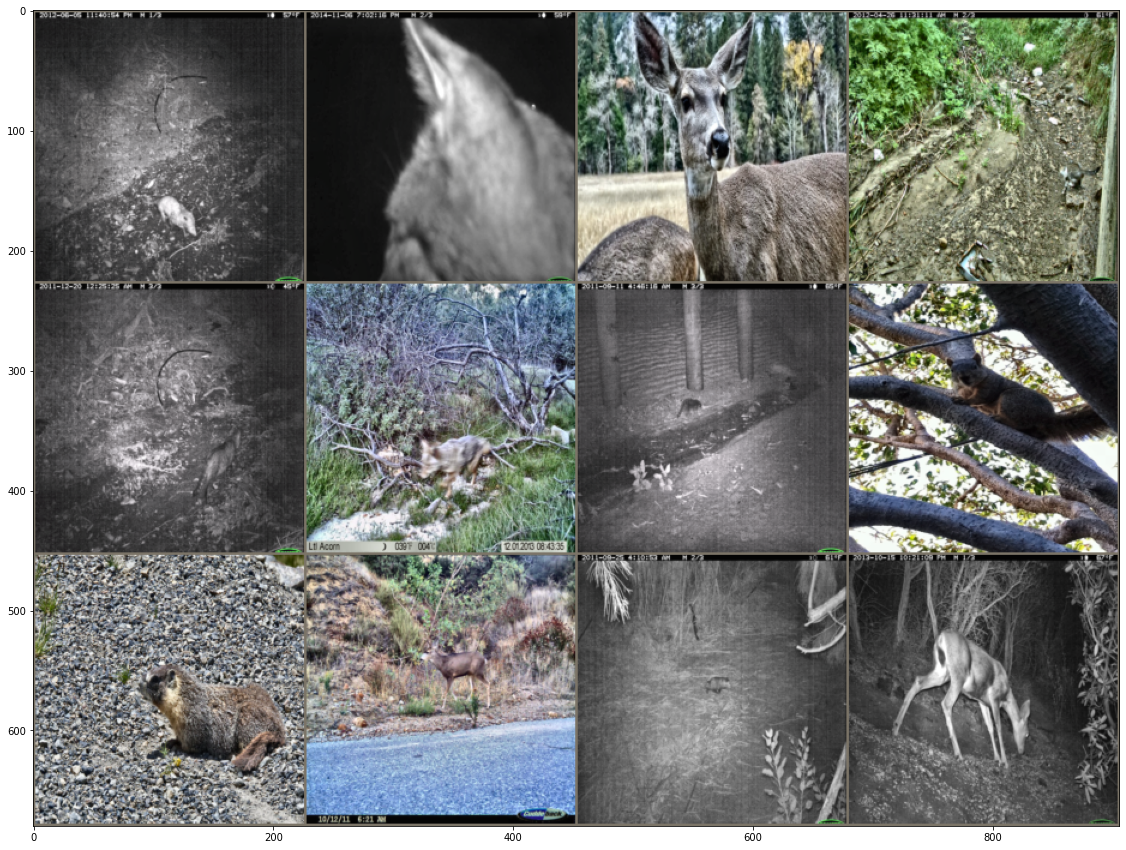

In [ ]:
# Get a batch of training data
inputs, _ = next(iter(train_loader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs, 4)

show_aug(out)
plt.show()

In [ ]:
_

tensor([0, 6, 4, 7, 7, 8, 3, 5, 5, 4, 0, 4])

In [ ]:
train_classes = sorted(filtered_train["category_id"].unique())
print(train_classes)
num_train_classes = len(train_classes)
print(f"Number of train classes: {num_train_classes}")

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
Number of train classes: 22


In [ ]:
RegNetY_16GF =torchvision.models.regnet_y_16gf(weights=torchvision.models.RegNet_Y_16GF_Weights.IMAGENET1K_SWAG_E2E_V1)

In [ ]:
RegNetY_16GF

RegNet(
  (stem): SimpleStemIN(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (trunk_output): Sequential(
    (block1): AnyStage(
      (block1-0): ResBottleneckBlock(
        (proj): Conv2dNormActivation(
          (0): Conv2d(32, 224, kernel_size=(1, 1), stride=(2, 2), bias=False)
          (1): BatchNorm2d(224, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (f): BottleneckTransform(
          (a): Conv2dNormActivation(
            (0): Conv2d(32, 224, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(224, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (b): Conv2dNormActivation(
            (0): Conv2d(224, 224, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=2, bias=False)
      

**Transfer Learning**

Replacing the last layer and freezing all others

In [ ]:
for param in RegNetY_16GF.stem.parameters():
    param.requires_grad = False

In [ ]:
#for swan:
# Freeze training for all layers
for param in RegNetY_16GF.trunk_output.parameters():
    param.requires_grad = False

# Newly created modules have require_grad=True by default
num_features = RegNetY_16GF.fc.in_features
features = list(RegNetY_16GF.fc.children())[:-1] # Remove last layer
features.extend([nn.Linear(num_features, num_train_classes)]) # Add our layer with 4 outputs
RegNetY_16GF.fc = nn.Sequential(*features) # Replace the model classifier
print(RegNetY_16GF)

RegNet(
  (stem): SimpleStemIN(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (trunk_output): Sequential(
    (block1): AnyStage(
      (block1-0): ResBottleneckBlock(
        (proj): Conv2dNormActivation(
          (0): Conv2d(32, 224, kernel_size=(1, 1), stride=(2, 2), bias=False)
          (1): BatchNorm2d(224, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (f): BottleneckTransform(
          (a): Conv2dNormActivation(
            (0): Conv2d(32, 224, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(224, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (b): Conv2dNormActivation(
            (0): Conv2d(224, 224, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=2, bias=False)
      

**Defining Loss Criterion and Optimizer**

In [ ]:
#for regnet
use_gpu = torch.cuda.is_available()
if use_gpu:
    RegNetY_16GF.cuda() #.cuda() will move everything to the GPU side
    
criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.Adam(RegNetY_16GF.parameters(), lr=0.0001)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


**Training the model**

In [ ]:
def train_model(vgg, criterion, optimizer, num_epochs=10):
    since = time.time()
    best_model_wts = copy.deepcopy(vgg.state_dict())
    best_acc = 0.0
    
    avg_loss = 0
    avg_acc = 0
    avg_loss_val = 0
    avg_acc_val = 0
    
    train_batches = len(train_loader)
    val_batches = len(val_loader)
    
    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch, num_epochs))
        print('-' * 10)
        
        loss_train = 0
        loss_val = 0
        acc_train = 0
        acc_val = 0
        
        vgg.train(True)
        
        for i, data in enumerate(train_loader):
            if i%10 ==0:
              print("\rTraining batch {}/{}".format(i, train_batches), flush=True)
                
            # Use half training dataset
            # if i >= train_batches / 2:
            #     break
                
            inputs, labels = data
            
            if use_gpu:
                inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
            else:
                inputs, labels = Variable(inputs), Variable(labels)
            
            optimizer.zero_grad()
            
            outputs = vgg(inputs)
            
            _, preds = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            loss_train += loss.data#[0]
            acc_train += torch.sum(preds == labels.data)
            
            del inputs, labels, outputs, preds
            # torch.cuda.empty_cache()
        
        print()
        # * 2 as we only used half of the dataset
        avg_loss = loss_train  / len(train)
        avg_acc = acc_train  / len(train)
        
        vgg.train(False)
        vgg.eval()
            
        for i, data in enumerate(val_loader):
            if i%10 ==0:
              print("\rValidation batch {}/{}".format(i, val_batches), flush=True)
                
            inputs, labels = data
            
            if use_gpu:
                inputs, labels = Variable(inputs.cuda(), volatile=True), Variable(labels.cuda(), volatile=True)
            else:
                inputs, labels = Variable(inputs, volatile=True), Variable(labels, volatile=True)
            with torch.no_grad():
              optimizer.zero_grad()
              
              outputs = vgg(inputs)
              
              _, preds = torch.max(outputs.data, 1)
              loss = criterion(outputs, labels)
              
              loss_val += loss.data#[0]
              acc_val += torch.sum(preds == labels.data)
              
              del inputs, labels, outputs, preds
              # torch.cuda.empty_cache()
        
        avg_loss_val = loss_val / len(val)
        avg_acc_val = acc_val / len(val)
        
        print()
        print("Epoch {} result: ".format(epoch))
        print("Avg loss (train): {:.4f}".format(avg_loss))
        print("Avg acc (train): {:.4f}".format(avg_acc))
        print("Avg loss (val): {:.4f}".format(avg_loss_val))
        print("Avg acc (val): {:.4f}".format(avg_acc_val))
        print('-' * 10)
        print()
        
        if avg_acc_val > best_acc:
            best_acc = avg_acc_val
            best_model_wts = copy.deepcopy(vgg.state_dict())
            torch.save(vgg.state_dict(), f'/content/gdrive/My Drive/kaggle/preprocessed_regnet_small50_aug_epoch{epoch}.pt')
        
    elapsed_time = time.time() - since
    print()
    print("Training completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
    print("Best acc: {:.4f}".format(best_acc))
    
    vgg.load_state_dict(best_model_wts)
    return vgg

In [ ]:
RegNetY_16GF.load_state_dict(torch.load("/content/gdrive/My Drive/kaggle/preprocessed_regnet_recommended_aug_epoch4.pt"))


<All keys matched successfully>

In [ ]:
RegNetY_16GF = train_model(RegNetY_16GF, criterion, optimizer_ft, num_epochs=4)


Epoch 0/4
----------
Training batch 0/4426
Training batch 10/4426
Training batch 20/4426
Training batch 30/4426
Training batch 40/4426
Training batch 50/4426
Training batch 60/4426
Training batch 70/4426
Training batch 80/4426
Training batch 90/4426
Training batch 100/4426
Training batch 110/4426
Training batch 120/4426
Training batch 130/4426
Training batch 140/4426
Training batch 150/4426
Training batch 160/4426
Training batch 170/4426
Training batch 180/4426
Training batch 190/4426
Training batch 200/4426
Training batch 210/4426
Training batch 220/4426
Training batch 230/4426
Training batch 240/4426
Training batch 250/4426
Training batch 260/4426
Training batch 270/4426
Training batch 280/4426
Training batch 290/4426
Training batch 300/4426
Training batch 310/4426
Training batch 320/4426
Training batch 330/4426
Training batch 340/4426
Training batch 350/4426
Training batch 360/4426
Training batch 370/4426
Training batch 380/4426
Training batch 390/4426
Training batch 400/4426
Traini

<ipython-input-241-2afa2a7b8d21>:71: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  inputs, labels = Variable(inputs.cuda(), volatile=True), Variable(labels.cuda(), volatile=True)


Validation batch 10/1107
Validation batch 20/1107
Validation batch 30/1107
Validation batch 40/1107
Validation batch 50/1107
Validation batch 60/1107
Validation batch 70/1107
Validation batch 80/1107
Validation batch 90/1107
Validation batch 100/1107
Validation batch 110/1107
Validation batch 120/1107
Validation batch 130/1107
Validation batch 140/1107
Validation batch 150/1107
Validation batch 160/1107
Validation batch 170/1107
Validation batch 180/1107
Validation batch 190/1107
Validation batch 200/1107
Validation batch 210/1107
Validation batch 220/1107
Validation batch 230/1107
Validation batch 240/1107
Validation batch 250/1107
Validation batch 260/1107
Validation batch 270/1107
Validation batch 280/1107
Validation batch 290/1107
Validation batch 300/1107
Validation batch 310/1107
Validation batch 320/1107
Validation batch 330/1107
Validation batch 340/1107
Validation batch 350/1107
Validation batch 360/1107
Validation batch 370/1107
Validation batch 380/1107
Validation batch 390/

KeyboardInterrupt: ignored

# Predictions

In [ ]:
test_df

date_captured                                 file_name  \
0       03-Jan-2016 11:30:56  bce932f6-2bf6-11e9-bcad-06f10d5896c4.jpg   
1       03-Jan-2016 11:30:57  bce932f7-2bf6-11e9-bcad-06f10d5896c4.jpg   
2       03-Jan-2016 11:30:58  bce932f8-2bf6-11e9-bcad-06f10d5896c4.jpg   
3       03-Jan-2016 11:30:59  bce932f9-2bf6-11e9-bcad-06f10d5896c4.jpg   
4       03-Jan-2016 11:31:00  bce932fa-2bf6-11e9-bcad-06f10d5896c4.jpg   
...                      ...                                       ...   
153725  25-Apr-2016 09:04:21  88613521-2c22-11e9-bcad-06f10d5896c4.jpg   
153726  25-Apr-2016 09:04:23  88613522-2c22-11e9-bcad-06f10d5896c4.jpg   
153727  25-Apr-2016 09:04:27  88613523-2c22-11e9-bcad-06f10d5896c4.jpg   
153728  25-Apr-2016 09:04:29  88613524-2c22-11e9-bcad-06f10d5896c4.jpg   
153729  25-Apr-2016 09:08:57  89994900-2c22-11e9-bcad-06f10d5896c4.jpg   

        frame_num                                    id  location  \
0               1  bce932f6-2bf6-11e9-bcad-06f10d5896c4        37   
1               2  bce932f7-2bf6-11e9-bcad-06f10d5896c4        37   
2               3  bce932f8-2bf6-11e9-bcad-06f10d5896c4        37   
3               4  bce932f9-2bf6-11e9-bcad-06f10d5896c4        37   
4               5  bce932fa-2bf6-11e9-bcad-06f10d5896c4        37   
...           ...                                   ...       ...   
153725         29  88613521-2c22-11e9-bcad-06f10d5896c4        16   
153726         30  88613522-2c22-11e9-bcad-06f10d5896c4        16   
153727         31  88613523-2c22-11e9-bcad-06f10d5896c4        16   
153728         32  88613524-2c22-11e9-bcad-06f10d5896c4        16   
153729          1  89994900-2c22-11e9-bcad-06f10d5896c4        16   

                            rights_holder  \
0       Idaho Department of Fish and Game   
1       Idaho Department of Fish and Game   
2       Idaho Department of Fish and Game   
3       Idaho Department of Fish and Game   
4       Idaho Department of Fish and Game   
...                                   ...   
153725  Idaho Department of Fish and Game   
153726  Idaho Department of Fish and Game   
153727  Idaho Department of Fish and Game   
153728  Idaho Department of Fish and Game   
153729  Idaho Department of Fish and Game   

                                      seq_id  seq_num_frames  width  height  \
0       6e9ac61c-2e32-11e9-90ef-dca9047ef277               5   1024     726   
1       6e9ac61c-2e32-11e9-90ef-dca9047ef277               5   1024     726   
2       6e9ac61c-2e32-11e9-90ef-dca9047ef277               5   1024     726   
3       6e9ac61c-2e32-11e9-90ef-dca9047ef277               5   1024     726   
4       6e9ac61c-2e32-11e9-90ef-dca9047ef277               5   1024     726   
...                                      ...             ...    ...     ...   
153725  6fd1a1e8-2e32-11e9-aeb7-dca9047ef277              32   1024     544   
153726  6fd1a1e8-2e32-11e9-aeb7-dca9047ef277              32   1024     544   
153727  6fd1a1e8-2e32-11e9-aeb7-dca9047ef277              32   1024     544   
153728  6fd1a1e8-2e32-11e9-aeb7-dca9047ef277              32   1024     544   
153729  6fd1a275-2e32-11e9-ac41-dca9047ef277               1   1024     544   

                                                file_path  
0       test_images/bce932f6-2bf6-11e9-bcad-06f10d5896...  
1       test_images/bce932f7-2bf6-11e9-bcad-06f10d5896...  
2       test_images/bce932f8-2bf6-11e9-bcad-06f10d5896...  
3       test_images/bce932f9-2bf6-11e9-bcad-06f10d5896...  
4       test_images/bce932fa-2bf6-11e9-bcad-06f10d5896...  
...                                                   ...  
153725  test_images/88613521-2c22-11e9-bcad-06f10d5896...  
153726  test_images/88613522-2c22-11e9-bcad-06f10d5896...  
153727  test_images/88613523-2c22-11e9-bcad-06f10d5896...  
153728  test_images/88613524-2c22-11e9-bcad-06f10d5896...  
153729  test_images/89994900-2c22-11e9-bcad-06f10d5896...  

[153730 rows x 11 columns]

**Filtering Test set using the detector**

We used the predictions of the detector on the test set- if the detector detected no animal- we classify the image as empty(0), otherwise- we filter the test set and apply our trained model on it to classify the animal category

In [ ]:
detections_test = pd.read_csv("preprocessed_detection_test_full.csv")

In [ ]:
detections_test

Unnamed: 0  0
0                0  0
1                1  0
2                2  0
3                3  0
4                4  0
...            ... ..
153725      153725  1
153726      153726  0
153727      153727  0
153728      153728  1
153729      153729  0

[153730 rows x 2 columns]

In [ ]:
test_df['file_path'] = test_df['id'].apply(lambda x: f'test_images/{x}.jpg')
test_df = test_df[['file_path','id']]
test_df.head()

file_path  \
0  test_images/bce932f6-2bf6-11e9-bcad-06f10d5896...   
1  test_images/bce932f7-2bf6-11e9-bcad-06f10d5896...   
2  test_images/bce932f8-2bf6-11e9-bcad-06f10d5896...   
3  test_images/bce932f9-2bf6-11e9-bcad-06f10d5896...   
4  test_images/bce932fa-2bf6-11e9-bcad-06f10d5896...   

                                     id  
0  bce932f6-2bf6-11e9-bcad-06f10d5896c4  
1  bce932f7-2bf6-11e9-bcad-06f10d5896c4  
2  bce932f8-2bf6-11e9-bcad-06f10d5896c4  
3  bce932f9-2bf6-11e9-bcad-06f10d5896c4  
4  bce932fa-2bf6-11e9-bcad-06f10d5896c4

In [ ]:
results = test_df.copy()
results["Predicted"]=-1
results

file_path  \
0       test_images/bce932f6-2bf6-11e9-bcad-06f10d5896...   
1       test_images/bce932f7-2bf6-11e9-bcad-06f10d5896...   
2       test_images/bce932f8-2bf6-11e9-bcad-06f10d5896...   
3       test_images/bce932f9-2bf6-11e9-bcad-06f10d5896...   
4       test_images/bce932fa-2bf6-11e9-bcad-06f10d5896...   
...                                                   ...   
153725  test_images/88613521-2c22-11e9-bcad-06f10d5896...   
153726  test_images/88613522-2c22-11e9-bcad-06f10d5896...   
153727  test_images/88613523-2c22-11e9-bcad-06f10d5896...   
153728  test_images/88613524-2c22-11e9-bcad-06f10d5896...   
153729  test_images/89994900-2c22-11e9-bcad-06f10d5896...   

                                          id  Predicted  
0       bce932f6-2bf6-11e9-bcad-06f10d5896c4         -1  
1       bce932f7-2bf6-11e9-bcad-06f10d5896c4         -1  
2       bce932f8-2bf6-11e9-bcad-06f10d5896c4         -1  
3       bce932f9-2bf6-11e9-bcad-06f10d5896c4         -1  
4       bce932fa-2bf6-11e9-bcad-06f10d5896c4         -1  
...                                      ...        ...  
153725  88613521-2c22-11e9-bcad-06f10d5896c4         -1  
153726  88613522-2c22-11e9-bcad-06f10d5896c4         -1  
153727  88613523-2c22-11e9-bcad-06f10d5896c4         -1  
153728  88613524-2c22-11e9-bcad-06f10d5896c4         -1  
153729  89994900-2c22-11e9-bcad-06f10d5896c4         -1  

[153730 rows x 3 columns]

In [ ]:
for i,pred in enumerate(detections_test["0"]):
  if pred ==0:
    results.iloc[i,2] = 0


In [ ]:
results

file_path  \
0       test_images/bce932f6-2bf6-11e9-bcad-06f10d5896...   
1       test_images/bce932f7-2bf6-11e9-bcad-06f10d5896...   
2       test_images/bce932f8-2bf6-11e9-bcad-06f10d5896...   
3       test_images/bce932f9-2bf6-11e9-bcad-06f10d5896...   
4       test_images/bce932fa-2bf6-11e9-bcad-06f10d5896...   
...                                                   ...   
153725  test_images/88613521-2c22-11e9-bcad-06f10d5896...   
153726  test_images/88613522-2c22-11e9-bcad-06f10d5896...   
153727  test_images/88613523-2c22-11e9-bcad-06f10d5896...   
153728  test_images/88613524-2c22-11e9-bcad-06f10d5896...   
153729  test_images/89994900-2c22-11e9-bcad-06f10d5896...   

                                          id  Predicted  
0       bce932f6-2bf6-11e9-bcad-06f10d5896c4          0  
1       bce932f7-2bf6-11e9-bcad-06f10d5896c4          0  
2       bce932f8-2bf6-11e9-bcad-06f10d5896c4          0  
3       bce932f9-2bf6-11e9-bcad-06f10d5896c4          0  
4       bce932fa-2bf6-11e9-bcad-06f10d5896c4          0  
...                                      ...        ...  
153725  88613521-2c22-11e9-bcad-06f10d5896c4         -1  
153726  88613522-2c22-11e9-bcad-06f10d5896c4          0  
153727  88613523-2c22-11e9-bcad-06f10d5896c4          0  
153728  88613524-2c22-11e9-bcad-06f10d5896c4         -1  
153729  89994900-2c22-11e9-bcad-06f10d5896c4          0  

[153730 rows x 3 columns]

**Filterint test set**

In [ ]:
np_detect = np.array(detections_test["0"])


In [ ]:
indexes = np.where(np_detect == 1)[0]
filtered_test = test_df.loc[indexes]

In [ ]:
filtered_test

file_path  \
15      test_images/bce93305-2bf6-11e9-bcad-06f10d5896...   
27      test_images/bdf1b43d-2bf6-11e9-bcad-06f10d5896...   
28      test_images/bdf1b43e-2bf6-11e9-bcad-06f10d5896...   
29      test_images/bdf1b43f-2bf6-11e9-bcad-06f10d5896...   
30      test_images/bdf1b440-2bf6-11e9-bcad-06f10d5896...   
...                                                   ...   
153718  test_images/8861351a-2c22-11e9-bcad-06f10d5896...   
153719  test_images/8861351b-2c22-11e9-bcad-06f10d5896...   
153720  test_images/8861351c-2c22-11e9-bcad-06f10d5896...   
153725  test_images/88613521-2c22-11e9-bcad-06f10d5896...   
153728  test_images/88613524-2c22-11e9-bcad-06f10d5896...   

                                          id  
15      bce93305-2bf6-11e9-bcad-06f10d5896c4  
27      bdf1b43d-2bf6-11e9-bcad-06f10d5896c4  
28      bdf1b43e-2bf6-11e9-bcad-06f10d5896c4  
29      bdf1b43f-2bf6-11e9-bcad-06f10d5896c4  
30      bdf1b440-2bf6-11e9-bcad-06f10d5896c4  
...                                      ...  
153718  8861351a-2c22-11e9-bcad-06f10d5896c4  
153719  8861351b-2c22-11e9-bcad-06f10d5896c4  
153720  8861351c-2c22-11e9-bcad-06f10d5896c4  
153725  88613521-2c22-11e9-bcad-06f10d5896c4  
153728  88613524-2c22-11e9-bcad-06f10d5896c4  

[99922 rows x 2 columns]

Creating custom loader for the test set

In [ ]:
class Test_WildDataset(Dataset):
    def __init__(self, df, transforms=None):
        self.df = df
        self.transforms = transforms

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image = preprocess_images(self.df.iloc[idx, 0])
        # image = cv2.imread(self.df.iloc[idx, 0])
        id = self.df.iloc[idx, 1]
        if self.transforms is not None:
            image = self.transforms(image)
        return image,id



In [ ]:
# iWildCam dataset
dataset_test = Test_WildDataset(df=filtered_test,
                            transforms=aug)


# Data loader
test_loader = DataLoader(dataset=dataset_test, batch_size=1, shuffle=False,num_workers=0)


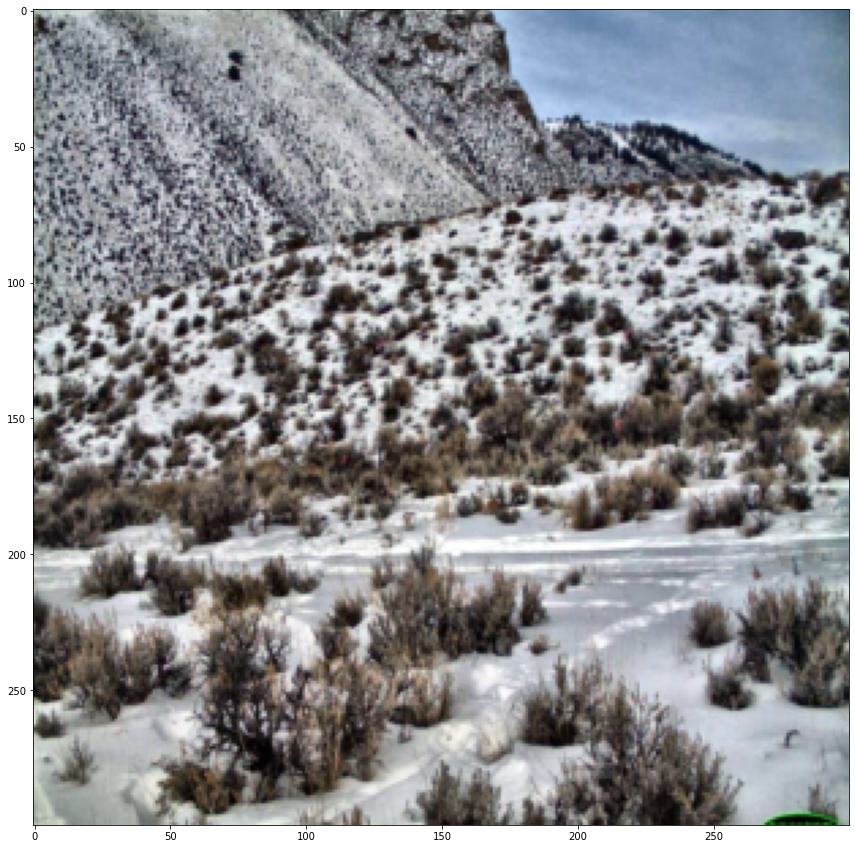

In [ ]:
# Get a batch of training data
inputs, _ = next(iter(test_loader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs, 4)

show_aug(out)
plt.show()

In [ ]:
_

In [ ]:
efficient_netb7.load_state_dict(torch.load(f'/content/gdrive/My Drive/kaggle/efficient_netb7_epoch4.pt'))

<All keys matched successfully>

In [ ]:
efficient_net_m.load_state_dict(torch.load(f'/content/gdrive/My Drive/kaggle/preprocessed_efficientnetm_epoch3.pt'))

<All keys matched successfully>

In [ ]:
label_dict = {0:19,1:8,2:4,3:13,4:1,5:3,6:16,7:17,8:11,9:14,10:18,11:10,12:22,13:5,14:12,15:7,16:15,17:20,18:21,19:9,20:6,21:2}

In [ ]:
label_dict

{0: 19,
 1: 8,
 2: 4,
 3: 13,
 4: 1,
 5: 3,
 6: 16,
 7: 17,
 8: 11,
 9: 14,
 10: 18,
 11: 10,
 12: 22,
 13: 5,
 14: 12,
 15: 7,
 16: 15,
 17: 20,
 18: 21,
 19: 9,
 20: 6,
 21: 2}

**Predicting using the trained model**

In [ ]:
RegNetY_16GF.eval()
RegNetY_16GF.to(device)
for i, data in tqdm(enumerate(test_loader)):
  inputs,id = data
  inputs= Variable(inputs.cuda(), volatile=True)
  with torch.no_grad():          
    outputs = RegNetY_16GF(inputs)
    _, preds = torch.max(outputs.data, 1)

    # print(label_dict[preds.cpu().numpy()[0]])
    idx = results.index[results["id"]==id[0]]
    results.iloc[idx,2]=label_dict[preds.cpu().numpy()[0]]

0it [00:00, ?it/s]<ipython-input-126-897036d52fcd>:5: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  inputs= Variable(inputs.cuda(), volatile=True)
99922it [1:23:56, 19.84it/s]


# Final Submission File

In [ ]:
final = results[["id","Predicted"]]
final.to_csv("final.csv",index=False)
from google.colab import files
files.download('final.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
final["Predicted"].value_counts()

1     62970
0     53808
21     8158
8      6779
13     4432
11     4385
3      3186
16     2970
12     2621
5      2546
10      690
4       397
9       277
14      164
20       95
17       77
22       74
7        57
19       17
2        17
18        6
6         4
Name: Predicted, dtype: int64

In [ ]:
final.to_csv('/content/gdrive/My Drive/kaggle/finall.csv')

In [ ]:
from google.colab import runtime
runtime.unassign()